# What Can You Expect In this Notebook?

## Goals
1. Create a collaborative filtering feature
1. Make book clustering

In [4]:
# import libraries (you may add additional imports but you may not have to)
import logging
logging.captureWarnings(True)

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

#viz lib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

#to scale the data using z-score
from sklearn.preprocessing import StandardScaler

#Importing PCA
from sklearn.decomposition import PCA

#
from surprise import Reader

In [5]:
df = pd.read_csv("data/clean_data.csv")

In [6]:
df["isbn_index"] = df["isbn"].astype("category").cat.codes

df.head()

,Unnamed: 0,isbn,book_title,book_author,year_of_publication,publisher,mod_title,user_id,book_rating,location,age,isbn_index
0,0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,classical mythology,2.0,0.0,"stockton, california, usa",18.0,24927
1,1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,8.0,5.0,"timmins, ontario, canada",24.0,73
2,2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,11400.0,0.0,"ottawa, ontario, canada",49.0,73
3,3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,11676.0,8.0,"n/a, n/a, n/a",24.0,73
4,4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,41385.0,0.0,"sudbury, ontario, canada",24.0,73


## Advice from freeCodeCamp
https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/book-recommendation-engine-using-knn<br>
If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

In [7]:
# Find how many books have each users read
user_stat = pd.pivot_table(
    data = df,
    values = 'book_title',
    index = 'user_id',
    aggfunc= 'count'
).reset_index()

In [8]:
user_stat.head()

,user_id,book_title
0,2.0,1
1,8.0,17
2,9.0,3
3,10.0,1
4,12.0,1


<AxesSubplot:xlabel='book_title', ylabel='Density'>

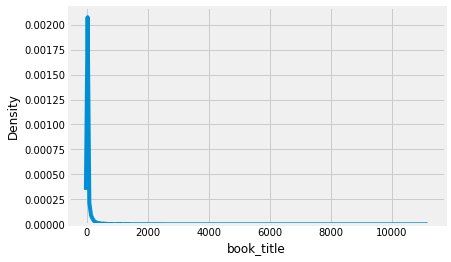

In [74]:
sns.kdeplot(
    data = user_stat['book_title'],
    # orient='h'
)

In [31]:
# Find how many books have each users read
book_stat = pd.pivot_table(
    data = df,
    values = 'book_rating',
    index = 'isbn',
    aggfunc= 'count'
).reset_index().rename(columns = {"book_rating":"total_like"})

temp = pd.pivot_table(
    data = df[df['book_rating']!=0],
    values = 'book_rating',
    index = 'isbn',
    aggfunc= np.mean
).reset_index().rename(columns = {"book_rating":"average_rating"})

book_stat = book_stat.merge(temp, how = 'left', on = 'isbn').fillna(0)

<AxesSubplot:xlabel='book_rating', ylabel='Density'>

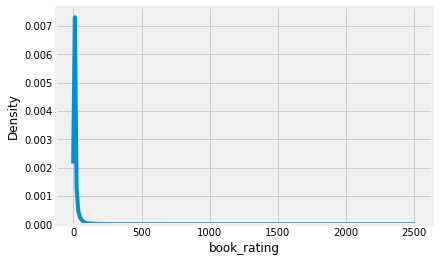

In [77]:
sns.kdeplot(
    data = book_stat['book_rating'],
    # orient='h'
)

In [42]:
used_user = user_stat[user_stat['book_title']>=200]['user_id'].astype('int')
used_user

87          254
698        2276
862        2766
919        2977
1033       3363
          ...  
90586    274308
91111    275970
91563    277427
91638    277639
91951    278418
Name: user_id, Length: 816, dtype: int32

In [43]:
used_book = book_stat[book_stat['total_like']>=100]['isbn']
used_book

1759      002542730X
3219      0060008032
3484      0060096195
3989      006016848X
4122      0060173289
             ...    
230080    1573227331
230142    1573229326
230152    1573229571
235748    1592400876
240805    1878424319
Name: isbn, Length: 727, dtype: object

In [45]:
df.head()

,Unnamed: 0,isbn,book_title,book_author,year_of_publication,publisher,mod_title,user_id,book_rating,location,age,isbn_index
0,0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,classical mythology,2.0,0.0,"stockton, california, usa",18.0,24927
1,1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,8.0,5.0,"timmins, ontario, canada",24.0,73
2,2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,11400.0,0.0,"ottawa, ontario, canada",49.0,73
3,3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,11676.0,8.0,"n/a, n/a, n/a",24.0,73
4,4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,41385.0,0.0,"sudbury, ontario, canada",24.0,73


In [52]:
#User-Book matrix
user_book_df = pd.pivot_table(
    data = df[(df['isbn'].isin(used_book)) & (df['user_id'].isin(used_user))],
    index="user_id", 
    columns="isbn_index", 
    values=["book_rating"]
    )

user_book_df += 1

user_book_df.fillna(0, inplace = True)

In [53]:
user_book_sparse = csr_matrix(user_book_df.values)

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

In [54]:
similarity_scores = cosine_similarity(user_book_sparse)

In [55]:
similarity_scores.shape

(812, 812)

In [56]:
user_book_sparse

<812x727 sparse matrix of type '<class 'numpy.float64'>'
	with 48358 stored elements in Compressed Sparse Row format>

In [ ]:
'0002005018'
def recommend(isbn):
    # index fetch
    index = np.where(user_book_sparse.column==isbn)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = books[books['Book-Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
        
        data.append(item)
    
    return data

In [81]:
#We chose a book
book_name=3989

book_name=user_book_df[book_name]
book_name.sort_values(ascending=False)

user_id
165308.0    10.0
255092.0    10.0
201017.0    10.0
257204.0    10.0
11676.0      9.0
            ... 
274061.0     NaN
274308.0     NaN
275970.0     NaN
277427.0     NaN
277639.0     NaN
Name: 3989, Length: 812, dtype: float64

In [82]:
user_book_df.corrwith(book_name).sort_values(ascending=False).head()

isbn_index
70831     1.0
150437    1.0
93659     1.0
38568     1.0
93788     1.0
dtype: float64

In [83]:
rec_book=user_book_df.corrwith(book_name).sort_values(ascending=False).head()
rec_book_list=list(rec_book.index)

rec_book_list

[70831, 150437, 93659, 38568, 93788]

In [86]:
#Authors of 5 books we recommend
df_author=df[["isbn_index","book_title","book_author"]]
df_author.head()

df1 = df_author.loc[df_author["isbn_index"].isin(rec_book_list)]

df2=df1.drop_duplicates(subset=["book_author","book_author"], keep="first")
df2

,isbn_index,book_title,book_author
69691,70831,Skipping Christmas,John Grisham
150097,38568,1st to Die: A Novel,James Patterson
188474,93788,The Virgin Suicides,Jeffrey Eugenides
236969,93659,Last Man Standing,David Baldacci
255424,150437,"Ahab's Wife: Or, The Star-Gazer: A Novel",Sena Jeter Naslund
